In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

from brusselator.config import config
from brusselator.datasets import BrusselatorParallelDataset

from utils.plot import load_model

from utils.dmaps import create_geometric_harmonics, nystrom

torch.set_default_dtype(config["TRAINING"]["dtype"])

page_width = 529/72

plt.style.use("paper.mplstyle")

In [2]:
# Load data
np.random.seed(42)

dataset_train = BrusselatorParallelDataset(
    config["DATA"]["n_train"], config["DATA"]["l_trajectories"], config["DATA"]["parameters"]
)
dataset_val = BrusselatorParallelDataset(
    config["DATA"]["n_val"], config["DATA"]["l_trajectories"], config["DATA"]["parameters"]
)
dataset_test = BrusselatorParallelDataset(
    config["DATA"]["n_test"], config["DATA"]["l_trajectories_test"], config["DATA"]["parameters"]
)

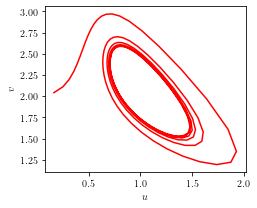

In [3]:
fig = plt.figure(figsize=(page_width/2, 3))
ax = fig.add_subplot(111)
# ax.plot(dataset_train.input_data[0], dataset_train.v_data[0], "-", color='red')
ax.plot(dataset_test.input_data[0], dataset_test.v_data[0], "-", color='red')
ax.set_xlabel(r"$u$")
ax.set_ylabel(r"$v$")
plt.tight_layout()
plt.savefig("brusselator/fig/brusselator_trajectory_uv.pdf")
plt.show()

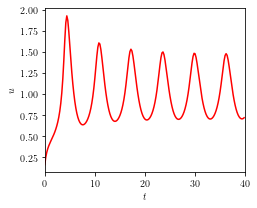

In [4]:
fig = plt.figure(figsize=(page_width/2, 3))
ax = fig.add_subplot(111)
# ax.plot(dataset_train.tt[:-1], dataset_train.input_data[0], "-", color="red")
ax.plot(dataset_test.tt[:-1], dataset_test.input_data[0], "-", color="red")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$u$")
ax.set_xlim((0, 40))
plt.tight_layout()
plt.savefig("brusselator/fig/brusselator_trajectory_u.pdf")
plt.show()

In [5]:
# Load model
model = load_model(dataset_train, dataset_val, config)

Using: cpu
Trainable parameters: 1025


/home/felix/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


  0%|          | 0/150 [00:00<?, ?it/s]

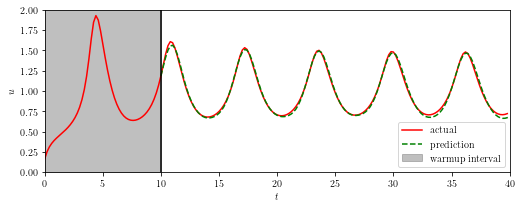

In [6]:
# Create predictions using warmup
idx = 0

start_point = config["DATA"]["max_warmup"]
warmup_length_list = [config["DATA"]["max_warmup"]]
warmup_length = warmup_length_list[0]

initial_condition = torch.tensor(dataset_test.input_data[idx], dtype=torch.get_default_dtype())
trajectory_w_warmup_initial, _ = model.integrate(
    initial_condition[start_point - warmup_length : start_point], len(dataset_test.tt) - start_point - 1
)

fig = plt.figure(figsize=(page_width, 3))
ax = fig.add_subplot(111)
ax.plot(dataset_test.tt[:-1], dataset_test.input_data[idx], "-", label="actual", color="red")
ax.plot(dataset_test.tt[warmup_length:], trajectory_w_warmup_initial[warmup_length:], "--", label="prediction", color="green")
ax.axvline(x=dataset_test.tt[start_point], color="k")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$u$")
ax.set_xlim((0, 40))
ax.set_ylim((0, 2))
ax.fill_between(x=[0, dataset_test.tt[start_point]], 
                y1=0, y2=2, color="gray", alpha=0.5, label="warmup interval")
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("brusselator/fig/brusselator_prediction_warmup.pdf")
plt.show()

In [7]:
# Create geometric harmonics
V, D, eps, x_chunks_train, c_chunks_train, interp_c = create_geometric_harmonics(
    dataset_train, dataset_test, config, model
)

Creating geometric harmonics.
Interpolation function.


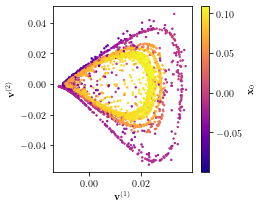

In [8]:
fig = plt.figure(figsize=(page_width/2, 3))
ax = fig.add_subplot(111)
scat = ax.scatter(V[:, 0], V[:, 1], c=c_chunks_train[:, 0], cmap="plasma", s=2)
ax.set_xlabel(r"$\mathbf{v}^{(1)}$")
ax.set_ylabel(r"$\mathbf{v}^{(2)}$")
plt.colorbar(scat, label=r"$\mathbf{x}_0$")
plt.tight_layout()
plt.savefig("brusselator/fig/brusselator_embedding_space.pdf")
plt.show()

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

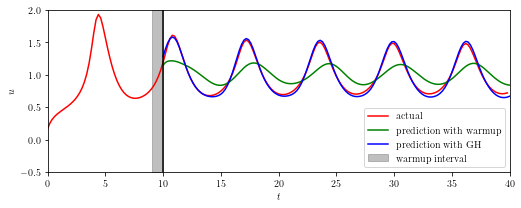

In [9]:
# Create trajectory with informed reservoir initialization
initial_test_chunk = dataset_test.input_data[
    idx, config["DATA"]["max_warmup"] - config["GH"]["gh_lenght_chunks"] : config["DATA"]["max_warmup"]
]

nystrom_test_chunk = nystrom(initial_test_chunk.reshape(1, -1), V, x_chunks_train, D, eps).T

h_pred = interp_c(nystrom_test_chunk)
trajectory_gh, _ = model.integrate(
    torch.tensor(initial_test_chunk[:1], dtype=torch.get_default_dtype()).to(model.device),
    T=len(dataset_test.tt) - config["DATA"]["max_warmup"] + config["GH"]["gh_lenght_chunks"] - 2,
    h0=torch.tensor(h_pred, dtype=torch.get_default_dtype()).to(model.device).unsqueeze(0),
)

trajectory_w_warmup, _ = model.integrate(
    torch.tensor(initial_test_chunk), len(dataset_test.tt) - config["DATA"]["max_warmup"] - 1
)


fig = plt.figure(figsize=(page_width, 3))
ax = fig.add_subplot(111)
ax.plot(dataset_test.tt[:-1], dataset_test.input_data[idx], label="actual", color="red")
# ax.plot(
#     dataset_test.tt[config["DATA"]["max_warmup"] - config["GH"]["gh_lenght_chunks"] :],
#     trajectory_w_warmup,
#     label="prediction with warmup", color="green"
# )
ax.plot(
    dataset_test.tt[config["DATA"]["max_warmup"]:], trajectory_w_warmup[config["GH"]["gh_lenght_chunks"] :],
    label="prediction with warmup", color="green"
)
# ax.plot(
#     dataset_test.tt[config["DATA"]["max_warmup"] - config["GH"]["gh_lenght_chunks"] :],
#     trajectory_gh,
#     label="prediction with GH", color="blue"
# )
ax.plot(
    dataset_test.tt[config["DATA"]["max_warmup"]:], trajectory_gh[config["GH"]["gh_lenght_chunks"]:],
    label="prediction with GH", color="blue"
)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$u$")
ax.set_xlim((0, 40))
ax.set_ylim((-0.5, 2))
ax.axvline(x=dataset_test.tt[start_point], color="k")
ax.fill_between(x=[dataset_test.tt[start_point-config["GH"]["gh_lenght_chunks"]], dataset_test.tt[start_point]], 
                y1=-0.5, y2=2, color="gray", alpha=0.5, label="warmup interval")
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("brusselator/fig/brusselator_predictions_gh.pdf")
plt.show()